# **1. 준비된 Custom Dataset 가져오기**

**1-1. 데이터 가져오기**
- VM에 dataset.zip 파일로 업로드 후 압축 풀기

In [ ]:
import zipfile

with zipfile.ZipFile('/content/dataset1.zip') as target_file:
    target_file.extractall('/content/dataset')

**1-2. 데이터 분할 및 학습할 폴더 구조 갖추기**

In [ ]:
import os
import shutil

current_path = os.path.abspath(os.curdir)
data_path = current_path + '/dataset'

test_percentage = 0.2  # test dataset percentage
val_percentage = 0   # val dataset percentage

image_paths = []
label_paths = []

# 데이터 분할
os.chdir(data_path)
for current_dir, dirs, files in os.walk('.'):
    for f in files:
        if f.endswith('.jpg'):
            image_path = current_path + '/dataset/' + f
            image_paths.append(image_path)
            fn = f.split('.')
            label_path = current_path + '/dataset/' + fn[0] + '.txt'
            label_paths.append(label_path)

# test dataset
image_paths_test = image_paths[:int(len(image_paths) * test_percentage)]
label_paths_test = label_paths[:int(len(label_paths) * test_percentage)]

# train dataset
image_paths = image_paths[int(len(image_paths) * test_percentage):]
label_paths = label_paths[int(len(label_paths) * test_percentage):]

# train dataset에서 다시 val dataset으로 분할
image_paths_val = image_paths[:int(len(image_paths) * val_percentage)]
label_paths_val = label_paths[:int(len(label_paths) * val_percentage)]

# 최종적인 train dataset
image_paths_train = image_paths[int(len(image_paths) * val_percentage):]
label_paths_train = label_paths[int(len(label_paths) * val_percentage):]

# train dataset 준비
if not os.path.exists('/content/train'):
  os.makedirs('/content/train/images')
  os.makedirs('/content/train/labels')

  for _source in image_paths_train:
    shutil.copy(_source, '/content/train/images')

  for _source in label_paths_train:
    shutil.copy(_source, '/content/train/labels')

# val dataset 준비
if not os.path.exists('/content/val'):
  os.makedirs('/content/val/images')
  os.makedirs('/content/val/labels')

  for _source in image_paths_val:
    shutil.copy(_source, '/content/val/images')

  for _source in label_paths_val:
    shutil.copy(_source, '/content/val/labels')

# test dataset 준비
if not os.path.exists('/content/test'):
  os.makedirs('/content/test/images')
  os.makedirs('/content/test/labels')

  for _source in image_paths_test:
    shutil.copy(_source, '/content/test/images')

  for _source in label_paths_test:
    shutil.copy(_source, '/content/test/labels')

# 작업 디렉토리를 다시 /content 로 변경
os.chdir('/content')

# **1-2. 준비된 Custom Dataset 가져오기(from roboflow.com)**

In [ ]:
!curl -L "https://app.roboflow.com/ds/5gzAoxt29G?key=IPMfpJbGQE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1613      0 --:--:-- --:--:-- --:--:--  1610
100 2420k  100 2420k    0     0   869k      0  0:00:02  0:00:02 --:--:-- 2188k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/fruit09_jpg.rf.e8b66ab955d8f5d3220948c983025116.jpg  
 extracting: test/images/fruit20_jpg.rf.7c78960af7111973a712336df2364966.jpg  
   creating: test/labels/
 extracting: test/labels/fruit09_jpg.rf.e8b66ab955d8f5d3220948c983025116.txt  
 extracting: test/labels/fruit20_jpg.rf.7c78960af7111973a712336df2364966.txt  
   creating: train/
   creating: train/images/
 extracting: train/images/fruit01_jpg.rf.08c43930f9ded7a063335405059def90.jpg  
 extracting: train/images/fruit01

**roboflow 에서 제공해준 yaml파일 확인해 보자.**

In [ ]:
!cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['Apple', 'Oriental melon', 'Tomato']

roboflow:
  workspace: jhsongok
  project: fruit_detection-ngi40
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/jhsongok/fruit_detection-ngi40/dataset/1

# **2. Custom yaml 파일을 만들자.**

In [ ]:
# PyYAML을 설치하자
!pip install PyYAML

In [ ]:
import yaml

data_cf = {'train' : '/content/train/images',
           'val' : '/content/test/images',
           'names' : ['Oriental melon', 'Tomato', 'Apple'],
           'nc' : 3 }

# fruit_data.yaml 이란 이름으로 custom yaml 파일을 만든다.
with open('/content/fruit_data.yaml', 'w') as f:
  yaml.dump(data_cf, f)

# fruit_data.yaml 확인
with open('/content/fruit_data.yaml', 'r') as f:
  fruit_yaml = yaml.safe_load(f)
  display(fruit_yaml)

{'names': ['Oriental melon', 'Tomato', 'Apple'],
 'nc': 3,
 'train': '/content/train/images',
 'val': '/content/test/images'}

# **3. YOLO11을 사용하기 위한 Setup(셋업)**

In [ ]:
# ultralytics 설치
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 17.0 MB/s eta 0:00:00


In [ ]:
# ultralytics 를 불러오고 체크
import ultralytics
ultralytics.checks()

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.5/112.6 GB disk)


# **4. Custom YOLO Training(학습)**

**Detection 모델로 사용할 수 있는 모델의 종류**

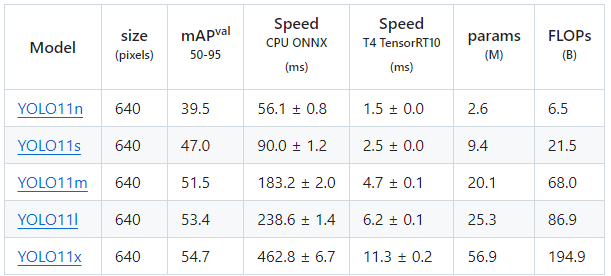

In [ ]:
# ultralytics에서 YOLO 모듈을 불러옴
from ultralytics import YOLO
# yolo11n.pt 모델의 아키텍처와 가중치을 함께 불러옴
model = YOLO('yolo11n.pt')

100%|██████████| 5.35M/5.35M [00:00<00:00, 84.8MB/s]


In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

**불러온 모델 아키텍처를 이용하여 우리가 준비한 Custom Dataset으로 학습을 시켜보자.**

In [ ]:
model.train(data='/content/fruit_data.yaml', epochs=100, patience=5, batch=8, imgsz=640)

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/fruit_data.yaml, epochs=100, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 26.6MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 1908.83it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/test/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 680.73it/s]

val: New cache created: /content/test/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.41G     0.4753       3.17     0.9534         60        640: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all          4         27     0.0082      0.444     0.0312     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.22G     0.4697      3.216     0.9555         53        640: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]

                   all          4         27     0.0107      0.571     0.0355     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.23G     0.4347      3.102     0.9463         55        640: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]

                   all          4         27     0.0124      0.619     0.0857     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.26G     0.5261      3.043     0.9675         71        640: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]

                   all          4         27     0.0142       0.69       0.12      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.26G     0.4797      2.879      0.952         62        640: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]

                   all          4         27      0.015      0.738      0.218      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.27G     0.4166      2.891      0.877         69        640: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]

                   all          4         27     0.0182      0.833      0.314      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.26G     0.4121      2.727     0.8984         69        640: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all          4         27      0.019      0.857      0.416      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       1.3G     0.4559       2.68      0.877         88        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all          4         27     0.0198      0.881      0.424      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.27G      0.443      2.599     0.8718         93        640: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all          4         27     0.0197      0.881      0.441       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.29G     0.4644      2.376     0.9271         83        640: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all          4         27     0.0205      0.905      0.488      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.29G     0.4132      2.295     0.8711         89        640: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]

                   all          4         27     0.0226          1      0.548      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.29G      0.423      2.216     0.8926         96        640: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

                   all          4         27     0.0226          1      0.548      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.26G     0.3898      2.087      0.847         69        640: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]

                   all          4         27     0.0226          1      0.621      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.26G     0.3863      1.843     0.8774         54        640: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]

                   all          4         27     0.0233          1       0.71      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       1.3G     0.4784      1.912     0.9159        115        640: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]

                   all          4         27     0.0233          1       0.71      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.28G     0.3895       1.73     0.8575        101        640: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]

                   all          4         27     0.0238          1      0.769      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.29G     0.3942      1.621      0.882        102        640: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]

                   all          4         27     0.0236          1      0.777      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.27G      0.468      1.369     0.9048         88        640: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]

                   all          4         27     0.0236          1      0.777      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.29G     0.5255      1.395     0.9596         81        640: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all          4         27     0.0217      0.905      0.794      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.27G     0.4989      1.277        0.9        104        640: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all          4         27     0.0217      0.905      0.794      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.26G     0.4706       1.29     0.9323         88        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all          4         27     0.0214      0.905      0.821      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.29G     0.4634      1.236     0.9016        138        640: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all          4         27     0.0214      0.905      0.821      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.26G     0.4503      1.183     0.9291        107        640: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all          4         27          1       0.12      0.862      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.26G     0.5049      1.093     0.9731         81        640: 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

                   all          4         27          1       0.12      0.862      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.26G      0.489       1.19     0.9721        112        640: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

                   all          4         27          1      0.203      0.869      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.27G     0.4936     0.9163     0.9259         69        640: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]

                   all          4         27          1      0.203      0.869      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.29G     0.4556     0.9527      0.904        134        640: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]

                   all          4         27          1      0.203      0.869      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.29G     0.5001      1.048     0.9466        104        640: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]

                   all          4         27          1      0.494      0.874      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.26G     0.4391     0.9345     0.9506         77        640: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]

                   all          4         27          1      0.494      0.874      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.26G     0.4695     0.9487     0.9582         52        640: 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]

                   all          4         27          1      0.734      0.869      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.25G     0.4047     0.7382      0.887         80        640: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

                   all          4         27          1      0.734      0.869      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.26G     0.4241     0.8216     0.9181         85        640: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]

                   all          4         27          1      0.734      0.869      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.29G     0.4428     0.8293     0.9377         89        640: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]

                   all          4         27      0.951      0.714      0.862      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.26G     0.4157     0.7581     0.8854        103        640: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all          4         27      0.951      0.714      0.862      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.25G     0.4438     0.7581     0.9455         80        640: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all          4         27      0.951      0.714      0.862      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.27G     0.4321     0.7921     0.9031         76        640: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all          4         27        0.9      0.734      0.859      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.24G     0.4521      0.855     0.9734         49        640: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


                   all          4         27        0.9      0.734      0.859      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.26G     0.4178     0.7429     0.9546         79        640: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

                   all          4         27        0.9      0.734      0.859      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.27G     0.4198     0.7566     0.9097         86        640: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]

                   all          4         27      0.927      0.845      0.882      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.26G      0.432     0.7307     0.9503         78        640: 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]

                   all          4         27      0.927      0.845      0.882      0.812
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


                   all          4         27      0.951      0.714      0.862      0.816
        Oriental melon          3          6          1      0.648      0.903      0.878
                Tomato          4         14          1      0.923       0.99      0.904
                 Apple          3          7      0.854      0.571      0.693      0.667
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aeeedbfe620>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# **5. Training(학습) 결과 확인**

**학습 결과를 그래프로 저장한 파일을 통해 확인해 본다**

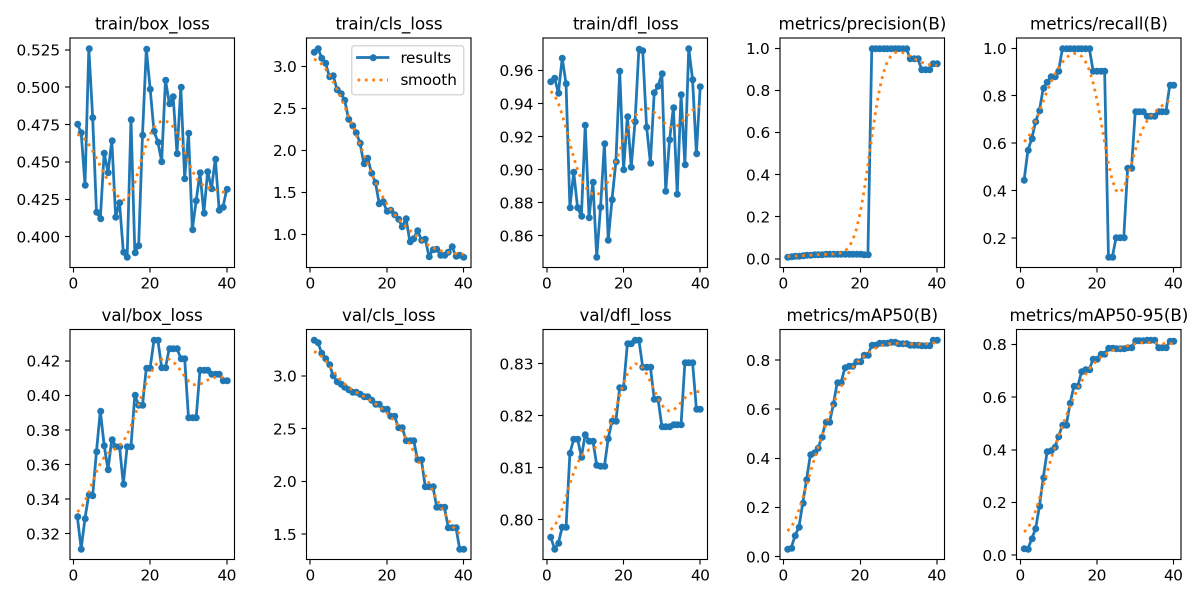

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

result_img = cv2.imread('/content/runs/detect/train/results.png')
fix_width = 1200
height,width = result_img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
result_img = cv2.resize(result_img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(result_img)

**Custom 모델이 분류할 수 있는 부류 확인**

In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 3
{0: 'Oriental melon', 1: 'Tomato', 2: 'Apple'}


# **6. Custom 모델로 Detection(검출)**

**Image Detection**

In [ ]:
# 모델 예측
results = model.predict(source='/content/test/images/fruit12.jpg', save=True)


image 1/1 /content/test/images/fruit12.jpg: 480x640 1 Oriental melon, 1 Tomato, 1 Apple, 41.7ms
Speed: 2.5ms preprocess, 41.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/train2


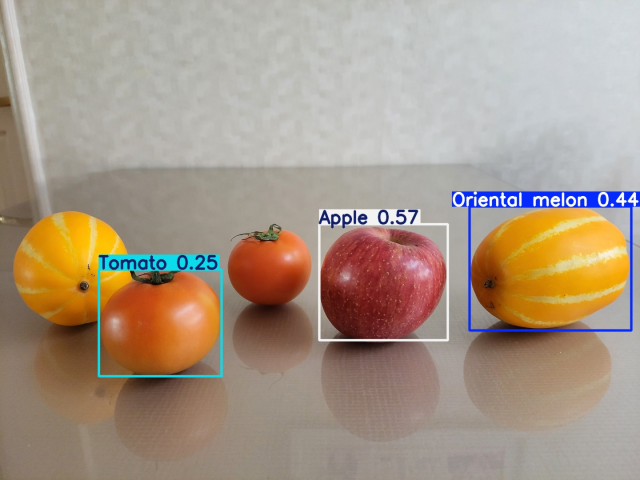

In [ ]:
# 예측 이미지 확인
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/runs/detect/train2/fruit12.jpg')
fix_width = 640
height,width = img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
img = cv2.resize(img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(img)

**Video Detection**

In [ ]:
# 동영상 예측
results = model.predict(source='/content/fruit.mp4', save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/892) /content/fruit.mp4: 384x640 (no detections), 44.3ms
video 1/1 (frame 2/892) /content/fruit.mp4: 384x640 (no detections), 10.2ms
video 1/1 (frame 3/892) /content/fruit.mp4: 384x640 (no detections), 9.5ms
video 1/1 (frame 4/892) /content/fruit.mp4: 384x640 (no detections), 11.8ms
video 1/1 (frame 5/892) /content/fruit.mp4: 384x640 (no detections), 11.8ms
video 1/1 (frame 6/892) /content/fruit.mp4: 384x640 (no detections), 8.8ms
vi

In [ ]:
# 코랩에서 영상을 보여줄 준비
import io
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(width, data_url))

In [ ]:
# avi 파일을 mp4 파일로 변환 후 영상을 보여줌
import os
path_video = os.path.join("/content/runs/detect/train3","fruit.avi")
%cd /content/runs/detect/train3
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!ffmpeg -y -loglevel panic -i "fruit.avi" "fruit.mp4"
%cd ../../../

# output object tracking video
path_output = os.path.join("/content/runs/detect/train3","fruit.mp4")
show_video(path_output, width=640)

Output hidden; open in https://colab.research.google.com to view.

# **7. 학습된 모델을 불러와 검출**

In [ ]:
# ultralytics 설치
!pip install ultralytics

# ultralytics 를 불러오고 체크
import ultralytics
ultralytics.checks()

In [ ]:
# ultralytics에서 YOLO 모듈을 불러옴
from ultralytics import YOLO
# 학습된 모델의 아키텍처와 가중치을 함께 불러옴
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 3
{0: 'Oriental melon', 1: 'Tomato', 2: 'Apple'}


In [ ]:
# 모델 예측
results = model.predict(source='/content/test/images/fruit15.jpg', save=True)


image 1/1 /content/test/images/fruit15.jpg: 480x640 6 Tomatos, 12.8ms
Speed: 9.2ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


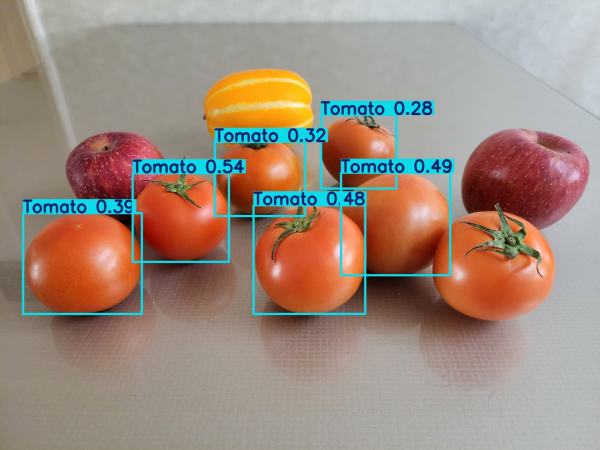

In [ ]:
# 예측 이미지 확인
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/runs/detect/predict/fruit15.jpg')
fix_width = 600
height,width = img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
img = cv2.resize(img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(img)